In [1]:
require 'nn'
require 'image'
local ParamBank = require 'ParamBank'

local SpatialConvolution = nn.SpatialConvolution
local SpatialConvolutionMM = nn.SpatialConvolutionMM
local SpatialMaxPooling = nn.SpatialMaxPooling

local cuda = false;

if cuda then
   require 'cunn'
   require 'cudnn'
   SpatialConvolution = cudnn.SpatialConvolution
   SpatialConvolutionMM = cudnn.SpatialConvolution
   SpatialMaxPooling = cudnn.SpatialMaxPooling
end

-- OverFeat input arguements
network  = 'small' or 'big'

-- system parameters
local threads = 4
local offset  = 0

torch.setdefaulttensortype('torch.FloatTensor')
torch.setnumthreads(threads)
print('==> #threads:', torch.getnumthreads())


local function nilling(module)
   module.gradBias   = nil
   if module.finput then module.finput = torch.Tensor():typeAs(module.finput) end
   module.gradWeight = nil
   module.output     = torch.Tensor():typeAs(module.output)
   module.fgradInput = nil
   module.gradInput  = nil
end

local function netLighter(network)
   nilling(network)
   if network.modules then
      for _,a in ipairs(network.modules) do
         netLighter(a)
      end
   end
end


net = nn.Sequential()
local m = net.modules
if network == 'small' then
   print('==> init a small overfeat network')
   net:add(SpatialConvolution(3, 96, 11, 11, 4, 4))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialMaxPooling(2, 2, 2, 2))
   net:add(SpatialConvolutionMM(96, 256, 5, 5, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialMaxPooling(2, 2, 2, 2))
   net:add(nn.SpatialZeroPadding(1, 1, 1, 1))
   net:add(SpatialConvolutionMM(256, 512, 3, 3, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(nn.SpatialZeroPadding(1, 1, 1, 1))
   net:add(SpatialConvolutionMM(512, 1024, 3, 3, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(nn.SpatialZeroPadding(1, 1, 1, 1))
   net:add(SpatialConvolutionMM(1024, 1024, 3, 3, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialMaxPooling(2, 2, 2, 2))
   net:add(SpatialConvolutionMM(1024, 3072, 6, 6, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialConvolutionMM(3072, 4096, 1, 1, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialConvolutionMM(4096, 1000, 1, 1, 1, 1))
   net:add(nn.View(1000))
   net:add(nn.SoftMax())
   net = net:float()
   print(net)

   -- init file pointer
   print('==> overwrite network parameters with pre-trained weigts')
   ParamBank:init("net_weight_0")
   ParamBank:read(        0, {96,3,11,11},    m[offset+1].weight)
   ParamBank:read(    34848, {96},            m[offset+1].bias)
   ParamBank:read(    34944, {256,96,5,5},    m[offset+4].weight)
   ParamBank:read(   649344, {256},           m[offset+4].bias)
   ParamBank:read(   649600, {512,256,3,3},   m[offset+8].weight)
   ParamBank:read(  1829248, {512},           m[offset+8].bias)
   ParamBank:read(  1829760, {1024,512,3,3},  m[offset+11].weight)
   ParamBank:read(  6548352, {1024},          m[offset+11].bias)
   ParamBank:read(  6549376, {1024,1024,3,3}, m[offset+14].weight)
   ParamBank:read( 15986560, {1024},          m[offset+14].bias)
   ParamBank:read( 15987584, {3072,1024,6,6}, m[offset+17].weight)
   ParamBank:read(129233792, {3072},          m[offset+17].bias)
   ParamBank:read(129236864, {4096,3072,1,1}, m[offset+19].weight)
   ParamBank:read(141819776, {4096},          m[offset+19].bias)
   ParamBank:read(141823872, {1000,4096,1,1}, m[offset+21].weight)
   ParamBank:read(145919872, {1000},          m[offset+21].bias)

elseif network == 'big' then
   print('==> init a big overfeat network')
   net:add(SpatialConvolution(3, 96, 7, 7, 2, 2))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialMaxPooling(3, 3, 3, 3))
   net:add(SpatialConvolutionMM(96, 256, 7, 7, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialMaxPooling(2, 2, 2, 2))
   net:add(nn.SpatialZeroPadding(1, 1, 1, 1))
   net:add(SpatialConvolutionMM(256, 512, 3, 3, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(nn.SpatialZeroPadding(1, 1, 1, 1))
   net:add(SpatialConvolutionMM(512, 512, 3, 3, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(nn.SpatialZeroPadding(1, 1, 1, 1))
   net:add(SpatialConvolutionMM(512, 1024, 3, 3, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(nn.SpatialZeroPadding(1, 1, 1, 1))
   net:add(SpatialConvolutionMM(1024, 1024, 3, 3, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialMaxPooling(3, 3, 3, 3))
   net:add(SpatialConvolutionMM(1024, 4096, 5, 5, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialConvolutionMM(4096, 4096, 1, 1, 1, 1))
   net:add(nn.Threshold(0, 1e-6))
   net:add(SpatialConvolutionMM(4096, 1000, 1, 1, 1, 1))
   net:add(nn.View(1000))
   net:add(nn.SoftMax())
   net = net:float()
   print(net)

   -- init file pointer
   print('==> overwrite network parameters with pre-trained weigts')
   ParamBank:init("net_weight_1")
   ParamBank:read(        0, {96,3,7,7},      m[offset+1].weight)
   ParamBank:read(    14112, {96},            m[offset+1].bias)
   ParamBank:read(    14208, {256,96,7,7},    m[offset+4].weight)
   ParamBank:read(  1218432, {256},           m[offset+4].bias)
   ParamBank:read(  1218688, {512,256,3,3},   m[offset+8].weight)
   ParamBank:read(  2398336, {512},           m[offset+8].bias)
   ParamBank:read(  2398848, {512,512,3,3},   m[offset+11].weight)
   ParamBank:read(  4758144, {512},           m[offset+11].bias)
   ParamBank:read(  4758656, {1024,512,3,3},  m[offset+14].weight)
   ParamBank:read(  9477248, {1024},          m[offset+14].bias)
   ParamBank:read(  9478272, {1024,1024,3,3}, m[offset+17].weight)
   ParamBank:read( 18915456, {1024},          m[offset+17].bias)
   ParamBank:read( 18916480, {4096,1024,5,5}, m[offset+20].weight)
   ParamBank:read(123774080, {4096},          m[offset+20].bias)
   ParamBank:read(123778176, {4096,4096,1,1}, m[offset+22].weight)
   ParamBank:read(140555392, {4096},          m[offset+22].bias)
   ParamBank:read(140559488, {1000,4096,1,1}, m[offset+24].weight)
   ParamBank:read(144655488, {1000},          m[offset+24].bias)

end
-- close file pointer
ParamBank:close()



==> #threads:	4	
==> init a small overfeat network	


nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> (13) -> (14) -> (15) -> (16) -> (17) -> (18) -> (19) -> (20) -> (21) -> (22) -> (23) -> output]
  (1): nn.SpatialConvolution
  (2): nn.Threshold
  (3): nn.SpatialMaxPooling
  (4): nn.SpatialConvolutionMM
  (5): nn.Threshold
  (6): nn.SpatialMaxPooling
  (7): nn.SpatialZeroPadding
  (8): nn.SpatialConvolutionMM
  (9): nn.Threshold
  (10): nn.SpatialZeroPadding
  (11): nn.SpatialConvolutionMM
  (12): nn.Threshold
  (13): nn.SpatialZeroPadding
  (14): nn.SpatialConvolutionMM
  (15): nn.Threshold
  (16): nn.SpatialMaxPooling
  (17): nn.SpatialConvolutionMM
  (18): nn.Threshold
  (19): nn.SpatialConvolutionMM
  (20): nn.Threshold
  (21): nn.SpatialConvolutionMM
  (22): nn.View
  (23): nn.SoftMax
}
{
  output : FloatTensor - empty
  gradInput : FloatTensor - empty
  modules : 
    {
      1 : 
        nn.SpatialConvolution
        {
          bias : FloatTensor - size: 96
      


          indices : FloatTensor - empty
          dW : 2
          gradInput : FloatTensor - empty
          output : FloatTensor - empty
          dH : 2
        }
      7 : 
        nn.SpatialZeroPadding
        {
          pad_l : 1
          gradInput : FloatTensor - empty
          pad_t : 1
          pad_b : 1
          pad_r : 1
          output : FloatTensor - empty
        }
      8 : 
        nn.SpatialConvolutionMM
        {
          padding : 0
          kW : 3
          nInputPlane : 256
          gradBias : FloatTensor - size: 512
          dW : 1
          gradWeight : FloatTensor - size: 512x2304
          output : FloatTensor - empty
          fgradInput : FloatTensor - empty
          finput : FloatTensor - empty
          bias : FloatTensor - size: 512
          weight : FloatTensor - size: 512x2304
          nOutputPlane : 512
          gradInput : FloatTensor - empty
          kH : 3
          dH : 1
        }
      9 : 
        nn.Threshold
        {
          v

   weight : FloatTensor - size: 1024x9216
          nOutputPlane : 1024
          gradInput : FloatTensor - empty
          kH : 3
          dH : 1
        }
      15 : 
        nn.Threshold
        {
          val : 1e-06
          output : FloatTensor - empty
          gradInput : FloatTensor - empty
          threshold : 0
        }
      16 : 
        nn.SpatialMaxPooling
        {
          kW : 2
          kH : 2
          indices : FloatTensor - empty
          dW : 2
          gradInput : FloatTensor - empty
          output : FloatTensor - empty
          dH : 2
        }
      17 : 
        nn.SpatialConvolutionMM
        {
          padding : 0
          kW : 6
          nInputPlane : 1024
          gradBias : FloatTensor - size: 3072
          dW : 1
          gradWeight : FloatTensor - size: 3072x36864
          output : FloatTensor - empty
          fgradInput : FloatTensor - empty
          finput : FloatTensor - empty
          bias : FloatTensor - size: 3072
          

 {
          gradInput : FloatTensor - empty
          output : FloatTensor - empty
        }
    }
}
==> overwrite network parameters with pre-trained weigts	


In [2]:
local label     = require 'overfeat_label'
local filename = 'bee.jpg'

if cuda then net:cuda() end

-- load and preprocess image
print('==> prepare an input image')
local img_dim
if network == 'small' then    dim = 231
elseif network == 'big' then  dim = 221 end
--local img_raw = image.load(filename):mul(255)
local img_raw = image.lena():mul(255)
local rh = img_raw:size(2)
local rw = img_raw:size(3)
if rh < rw then
   rw = math.floor(rw / rh * dim)
   rh = dim
else
   rh = math.floor(rh / rw * dim)
   rw = dim
end
local img_scale = image.scale(img_raw, rw, rh)

local offsetx = 1
local offsety = 1
if rh < rw then
   offsetx = offsetx + math.floor((rw-dim)/2)
else
   offsety = offsety + math.floor((rh-dim)/2)
end
img = img_scale[{{},{offsety,offsety+dim-1},{offsetx,offsetx+dim-1}}]:floor()


-- feedforward network
print('==> feed the input image')
timer = torch.Timer()
img:add(-118.380948):div(61.896913)  -- fixed distn ~ N(118.380948, 61.896913^2)
if cuda then 
   img = img:cuda():view(1, img:size(1), img:size(2), img:size(3))
   local out = net:forward(img):clone():float()
   prob, idx = torch.max(out[1], 1)
else
   prob, idx = torch.max(net:forward(img), 1)
end
print(label[idx:squeeze()], prob:squeeze())
print('Time elapsed: ' .. timer:time().real .. ' seconds')

==> prepare an input image	


==> feed the input image	


wig	0.14235188066959	
Time elapsed: 0.3010401725769 seconds	


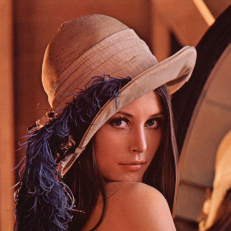

{
  output : FloatTensor - size: 1000
}


./predictions.lua:15: attempt to call method 'size' (a nil value)
stack traceback:
	./predictions.lua:15: in function 'init'
	./predictions.lua:8: in function 'new'
	[string "..."]:5: in main chunk
	[C]: in function 'xpcall'
	/opt/boxen/homebrew/share/lua/5.1/itorch/main.lua:177: in function </opt/boxen/homebrew/share/lua/5.1/itorch/main.lua:143>
	/opt/boxen/homebrew/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/opt/boxen/homebrew/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/opt/boxen/homebrew/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/opt/boxen/homebrew/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/opt/boxen/homebrew/share/lua/5.1/itorch/main.lua:344: in main chunk
	[C]: in function 'require'
	[string "arg={'/Users/fcarey/.ipython/profile_default/..."]:1: in main chunk: 

In [3]:

Predictions = require 'predictions'
itorch.image(img)
output = net:forward(img)
pred_a = Predictions:new{output = output}
pred_a:sort()


In [4]:
pred_a:getN(10)

{
  1 : 
    {
      category_id : 899
      label : wig
      confidence : 0.14235188066959
    }
  2 : 
    {
      category_id : 881
      label : cowboy hat, ten-gallon hat
      confidence : 0.092661067843437
    }
  3 : 
    {
      category_id : 925
      label : sombrero
      confidence : 0.072235994040966
    }
  4 : 
    {
      category_id : 868
      label : shower cap
      confidence : 0.061889663338661
    }
  5 : 
    {
      category_id : 911
      label : gown
      confidence : 0.051895651966333
    }
  6 : 
    {
      category_id : 938
      label : sarong
      confidence : 0.032304331660271
    }
  7 : 
    {
      category_id : 782
      label : maillot
      confidence : 0.031748186796904
    }
  8 : 
    {
      category_id : 872
      label : brassiere, bra, bandeau
      confidence : 0.029202098026872
    }
  9 : 
    {
      category_id : 909
      label : bath towel
      confidence : 0.028396707028151
    }
  10 : 
    {
      category_id : 880
      lab

./predictions.lua:4: attempt to index local 'output' (a nil value)
stack traceback:
	./predictions.lua:4: in function 'init'
	[string "Predictions = require 'predictions'..."]:2: in main chunk
	[C]: in function 'xpcall'
	/opt/boxen/homebrew/share/lua/5.1/itorch/main.lua:177: in function </opt/boxen/homebrew/share/lua/5.1/itorch/main.lua:143>
	/opt/boxen/homebrew/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/opt/boxen/homebrew/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/opt/boxen/homebrew/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/opt/boxen/homebrew/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/opt/boxen/homebrew/share/lua/5.1/itorch/main.lua:344: in main chunk
	[C]: in function 'require'
	[string "arg={'/Users/fcarey/.ipython/profile_default/..."]:1: in main chunk: 

[string "predictions_table = predictions:get(output)..."]:1: attempt to call method 'get' (a nil value)
stack traceback:
	[string "predictions_table = predictions:get(output)..."]:1: in main chunk
	[C]: in function 'xpcall'
	/opt/boxen/homebrew/share/lua/5.1/itorch/main.lua:177: in function </opt/boxen/homebrew/share/lua/5.1/itorch/main.lua:143>
	/opt/boxen/homebrew/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/opt/boxen/homebrew/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/opt/boxen/homebrew/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/opt/boxen/homebrew/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/opt/boxen/homebrew/share/lua/5.1/itorch/main.lua:344: in main chunk
	[C]: in function 'require'
	[string "arg={'/Users/fcarey/.ipython/profile_default/..."]:1: in main chunk: 